# Indroduzione

L'obiettivo del progetto è di fare una analisi dei dati sul controllo qualità dell'acqua e dopo passare alla predizione del modello, il dataset utilizzato consiste in diverse caratteristiche dell'acqua e dirci se questa è potabile o non

## Aggiornamento

Il commento sotto è rivolto al coach (esperto del settore) dopo aver ricevuto il suo feedback

Prima di tutto ringrazio molto per il feedback e i suggerimenti dati, mi ha aperta la mente in alcuni parti:
-  Bilanciatura dei dati, sapevo che i dati sbilanciati avrebbero portato un possibile pregiudizio da parte del modello, ma essendo un 6:4 non credevo che sarebbe stato cosi problematico (PS colpa mia che non ho fatto una prova)
- Poi sulla questione del utilizzare piu valori per il random_state, tendenzialmente usavo il 42 per il fatto che credevo che fosse un ottima metrica (guardando vari siti lo si vede spesso), poi visto che lo ha menzionato sono andato a fare una piccola ricerca per poi scoprire che il 42 era una specie di scherzo, ogni tanto si scopre cose molto divertenti, provando anche lo fissagio del seed (3 codici menzionanti) da quello che ho capito hanno l'utilità nel fixare il seed in modo che i modelli ottengano lo stesso risultato? (anche senza utilizzo del random_state o almeno e quello che ho letto su internet?), infine ho anche fatto delle prove con valori diversi del seed ma principalmente il 42 mostrava i risultati migliori
- Utilizzo delle Flag, stranamente era qualcosa che avevo già usato in precedenza ma non mi è venuta in mente nel momento dello svolgimento del progetto, comunque ora lo terro a mente, cosi facendo diventa molto più leggibile (ammetto che facendo un veloce controllo prima di mandarti il progetto ogni tanto mi perdevo su queste variabili....)
- Trattamento dei dati mancanti, metodo interessante come alternativa invece di usare un modello imputer, ma facendo cosi nel dataset intero, prima dello split train-test, non si rischia che con utilizzo del modello riesca a vedere un po i dati dello test o non si tratta di un grande problema in generale? o solo in questo caso?  
- Lo studio dello skewness e correzione mi è nuova, davvero interessante in alcuni casi dove ci sono distribuzione asimetriche, anche se non ho visto differenze nelle performance (facendo un confronto, skew=False, in alcuni casi ho visto un leggero peggioramento)

In alcune parti della preparazione della predizione ho impostato delle flag per fare delle prove se portano dei miglioramenti nelle performance, comunque ho impostato in false se causavano un peggioramento o stessi risultati, in piu notiamo in questo caso che la bilanciatura dei dati e utilizzo della mediana per riempire i dati nan rispetto alla eliminazione dei dati contenenti data nan si rivela un fattore chiave per le performance del accuracy (metrica scelta)    

In conclusione con i suggerimenti applicati ho migliorato circa del 10% accuracy del test e nel cross validation accuracy rispetto al precedente in linea con i suoi risultati.

Ps. ho inserito nel celle del testo #nome per le modifiche fatte

# Iniziamo

## Importo i moduli neccessari

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_selection import f_classif, SelectKBest
from scipy import stats
from imblearn.over_sampling import SMOTE
import random
import torch

In [2]:
sns.set(style="white", palette='bright', color_codes=True, font_scale=1.8)

## Carico i dati

Se si usa google colab se no salta

In [3]:
#from google.colab import files
#uploaded = files.upload()

In [4]:
dataset =  pd.read_csv('water_potability.csv')
dataset

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


## Analizzo i dati

In questa parte mi occuppero della visualizzazione dei grafici e una generale analizamento dei dati oltre al T_test

### Valori anomali ? (tipo caratteri speciali, lettere, ecc.. , valori mancanti esclusi)

In [5]:
dataset.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [6]:
dataset.dtypes

ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object

Bene, noto che sono tutti valori numerici

### Dati mancanti ?

In [7]:
dataset.isnull().any().any()

True

Numero di valori nan per colonna

In [8]:
dataset.isnull().sum() 

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Numero di righe con valori nan

In [9]:
len(dataset[dataset.isnull().any(axis=1)]) 

1265

I dati mancanti sono davvero tanti rappresentano circa 1/3 del intero dataset

Il modo più semplice di gestirli sarebbe quello di eliminarli ma perdero circa 1/3 di dati che potrebbe essere molto utili per la predizione, trattero questa parte nella fase della predizione

### Visualizziamo dei grafici

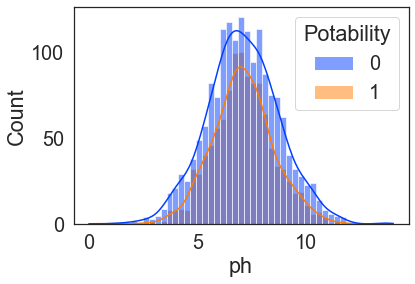

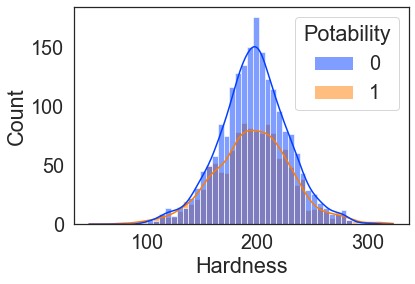

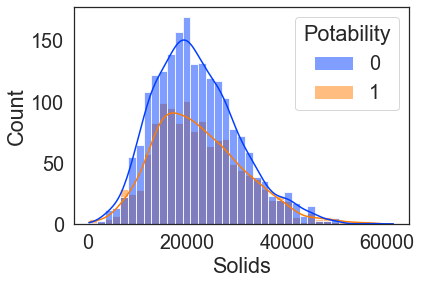

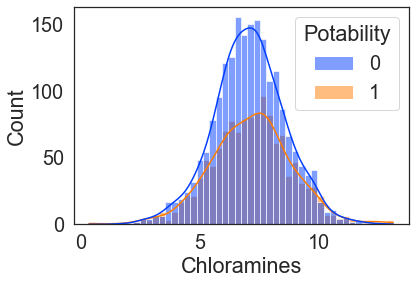

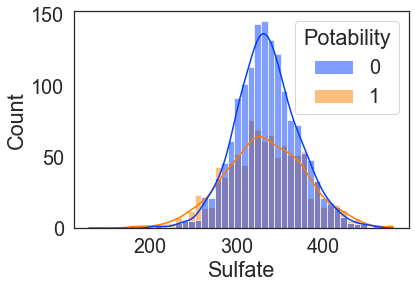

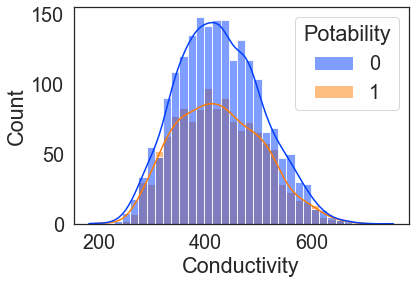

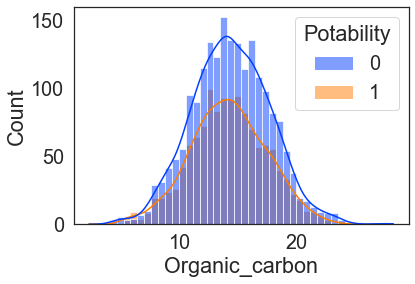

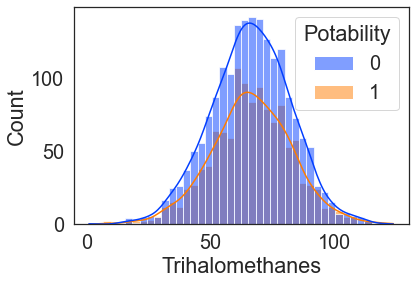

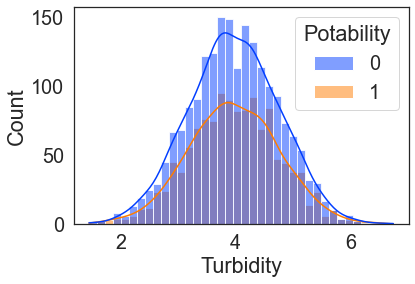

Wall time: 2.48 s


In [10]:
%%time
for i in dataset.columns[:9]:
    sns.histplot(data=dataset, x=i, hue='Potability', kde=True)
    plt.show()

Visualizzando i grafici si nota che che l'andamento tende a essere abbastanza simili tra le classi

Proviamo a visualizzare con 2 variabili

Wall time: 7.3 s


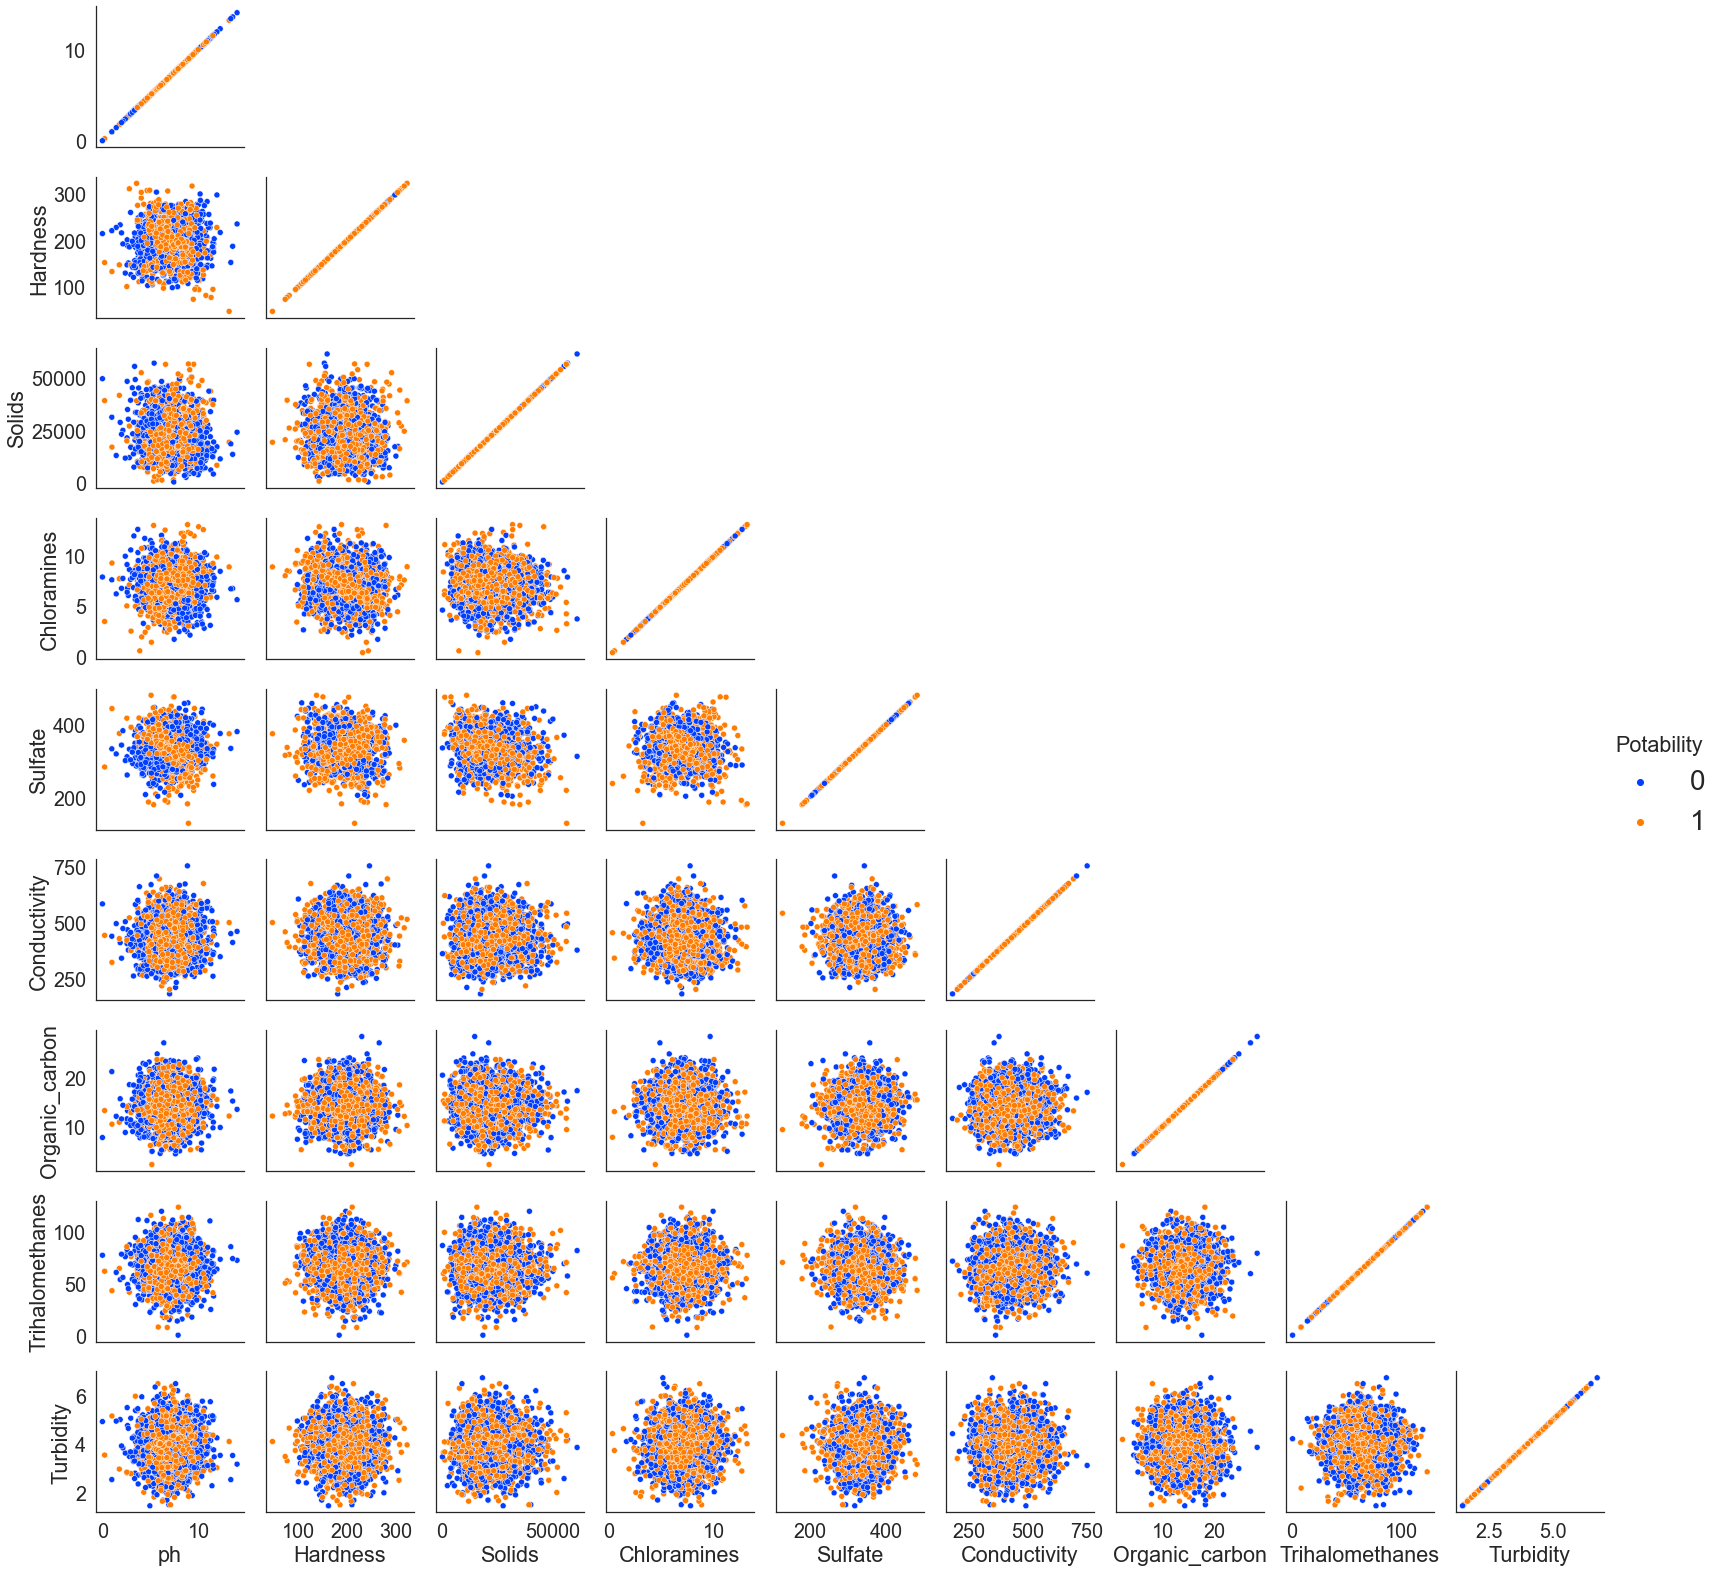

In [11]:
%%time
g = sns.PairGrid(dataset, corner = True, hue='Potability')
g.map(sns.scatterplot)
g.add_legend(fontsize=28)

Visualizzando i grafici con 2 variabili alcuni variabili tendono a essere rumorosi (casuali) mentre altre tendono a stare in un particolare intervallo, notiamo anche dei dati sparsi nei angoli anche se non sono tanti, gli outlier (dati anomali)

Provo a vedere una correlazione tra le colonne

<AxesSubplot:>

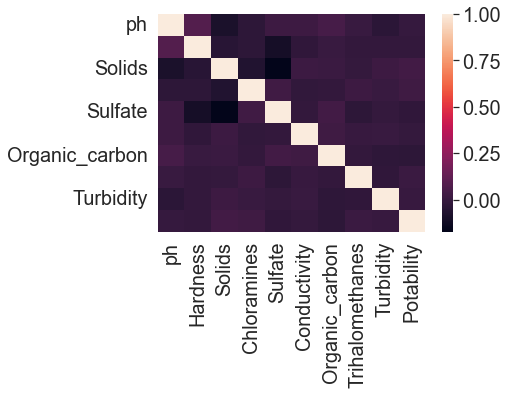

In [12]:
sns.heatmap(dataset.corr())

Notiamo che le colonne non sono correlate se non su loro stessi

### T_testing

L'ipotesi nulla afferma che non ci sia differenza oppure non vi sia relazione tra due fenomeni misurati, o associazione tra due gruppi. (fonte:wikipedia)                                                          
Per affermare cio si usa il p value che ha un valore da 0 (differenza) a un valore a 1 (nessuna differenza).

Per il test utilizzero i valori p value < 0.05 per rifiutare l'ipotesi e viceversa per non rifiutare.

In [13]:
no_null = dataset.dropna() # Per effetuare il test è neccessario che il dataset non presenti valori nan 
potability = no_null[no_null['Potability'] == 1]
non_potability = no_null[no_null['Potability'] == 0]
for i in potability.columns[:9]:
    stat, p = stats.stats.ttest_ind(potability[i], non_potability[i])
    print(i, (20-len(i))* '-' , 'stat = ', stat, '-'*5 ,'p value = ', p)

ph ------------------ stat =  0.6513321851789707 ----- p value =  0.5149065707812117
Hardness ------------ stat =  -0.06745790602377671 ----- p value =  0.9462238843628968
Solids -------------- stat =  1.8246028233684708 ----- p value =  0.06820943709932177
Chloramines --------- stat =  0.9317614076854305 ----- p value =  0.3515717996475366
Sulfate ------------- stat =  -0.6859960849551608 ----- p value =  0.49279473356494874
Conductivity -------- stat =  -0.6946306648287465 ----- p value =  0.4873671119496168
Organic_carbon ------ stat =  -0.6978279578419678 ----- p value =  0.4853655467227792
Trihalomethanes ----- stat =  0.4143559868879204 ----- p value =  0.6786576528825539
Turbidity ----------- stat =  1.0169290497986059 ----- p value =  0.30930963202416595


Possiamo notare che i valori dei campioni esaminati non è possibile rifiutare l'ipotesi nulla anche se il dato solids ci è abbastanza vicino

In conclusione possiamo dedurre che sono neccesari piu features insieme per poter classificare il target (potability, no potability)

Ora che abbiamo finito di analizzare i dati passiamo al processo di predizione

## Predizione

Obiettivo della predizione è saperci dirci se l'acqua con queste caraterristiche è potabile (1) o non potabile (0)

Nel processo della predizione andrò a usare 3 modelli e infine sceglierò i 2 modelli con il piu alto cross_validation_score e oltre a ottimizare i iperparmetri lo testero sui dati che non ha mai visto e vedere come si comporta, in questa fase verra diviso in 2 parti:
- Fase 1 andro a utilizzare tutte le feature.
- Fase 2 andrò a scegliere le feature più rilevanti secondo la Mutual Information o l’ANOVA f-test.

### Preparazione

Tutti i dati dovrebbero essere in formato float essendo valori numerici con eccezione della colonna potability che si tratta di una classe (potabile, non potabile)

In [14]:
dataset.dtypes

ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object

In [15]:
dataset['Potability'] = dataset['Potability'].astype('category')
dataset['Potability'].dtypes

CategoricalDtype(categories=[0, 1], ordered=False)

### #Distribuzione asimetriche

Visualizzando i grafici sopra notiamo che nella parte di solids e conductivity si mostra un specie asimetria verso sinistra, cercando di rendere i dati piu simmetrici rende potenzialmente piu interpretabile l'utilizzo della media come mostrato dal link che mi ha elencato

In [16]:
dataset.skew(axis = 0, skipna = True, numeric_only=True)

ph                 0.025630
Hardness          -0.039342
Solids             0.621634
Chloramines       -0.012098
Sulfate           -0.035947
Conductivity       0.264490
Organic_carbon     0.025533
Trihalomethanes   -0.083031
Turbidity         -0.007817
dtype: float64

Come previsto solids e conductivity tendono a mostrare valori positivi lontano da zero cerchiamo di riportarli vicino a zero per fare in modo che siano simmetriche

In [17]:
skew = False

if skew:
    dataset = dataset.apply(lambda x: np.log(x) if x.name =='Conductivity' else x)
    dataset = dataset.apply(lambda x: np.power(x, 3) if x.name =='Conductivity' else x)
    dataset = dataset.apply(lambda x: np.log(x) if x.name =='Solids' else x)
    dataset = dataset.apply(lambda x: np.power(x, 6) if x.name =='Solids' else x)
    print(dataset.skew(axis = 0, skipna = True, numeric_only=True))

Confrontando i risultati tende a avere un leggero peggioramento nel test quindi non lo attivero

### #Trattamento dei dati mancanti

In [18]:
len(dataset[dataset.isnull().any(axis=1)]) # Numero di righe con valori nan

1265

#Come avevamo detto precedentemente la quantità di dati mancanti è davvero grande, eliminando le righe porterebbe alla mancanza di alcuni dati molto importanti per classificare, quindi convertiro i valori nan nella loro media (PS: avendo imposto i dati in modo piu simmetrico nel passagio precedente, utilizzero la media).                   

In [19]:
fillmissdata = True

if fillmissdata:
    dataset['ph'] = dataset['ph'].fillna(dataset.groupby(['Potability'])['ph'].transform('median'))
    dataset['Sulfate'] = dataset['Sulfate'].fillna(dataset.groupby(['Potability'])['Sulfate'].transform('median'))
    dataset['Trihalomethanes'] = dataset['Trihalomethanes'].fillna(dataset.groupby(['Potability'])['Trihalomethanes'].transform('median'))
else:
    dataset = dataset.dropna()

# Metodo molto interessante che consiste nel riempire i valori nan con le medie delle no potability e potability delle rispettive colonne 

#Avendo messo false su skew impostero median che tende a essere un buona metrica durante le asimetrie rispetto alla media

Indico x i dati utilizzati per predire mentre indico y i dati per la previsione

In [20]:
x = dataset.drop(columns='Potability')
y = dataset['Potability']

### #Divido il dataset in train e test (il test saranno i dati mai visti), poi richiamo la funzione della convalida incrociata

In [21]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=seed, stratify=y)
skf = StratifiedKFold(n_splits=5)

#Imposto un seed per fixare il modo di mescolare i dati per ottenere piu o meno i stessi risultati quando si riavvia il notebook

Utilizzo lo stratify = y per far in modo che il y_train e il y_test abbiano valori bilanciati

### Outlier

Come visto dal grafico sopra, anche se pochi, sono presenti dei outlier (valori anomali) questi potrebbero distorcere il modello quindi è meglio trattarli.
Utilizzero il modello isolation forest per trattarli, che andra a rimuoveri i possibili valori sospetti

In [22]:
outlier = True
print('Dati completi ', x_train.shape, y_train.shape)

if outlier:
    
    # il modello indica se la riga in questione è un valore anomalo (-1) o un valore non anomalo (1)
    iso = IsolationForest(contamination=0.1, random_state=seed) # un valore alto del contamination tende a essere più rigido nella selezione
    
    try:
        
        yhat = iso.fit_predict(x_train.values) # aggiungo values per evitare un userwarning
         
        # Tolgo dal dataset tutti i possibili valori sospetti indicati dal modello
        mask = yhat != -1 
        x_train, y_train = x_train.iloc[mask, :], y_train.iloc[mask] 
        
    except: # se i dati sono sottoforma di array
        
        yhat = iso.fit_predict(x_train)
        mask = yhat != -1 
        x_train, y_train = x_train[mask, :], y_train[mask]
    
print('Dati dopo la rimozione di valori sospetti', x_train.shape, y_train.shape)

Dati completi  (2194, 9) (2194,)
Dati dopo la rimozione di valori sospetti (1974, 9) (1974,)


Ha rimosso circa 200 righe di dati

### #Dati bilanciati o non (guardo la y)

In [23]:
print(y_train.value_counts(1))

0    0.622594
1    0.377406
Name: Potability, dtype: float64


#I dati sulle potability sono divisi in 6:4, quindi cerco di bilanciarli in modo che il rapporto vada a 1:1 

In [24]:
# Aggiornamento
balance = True

if balance: 
    samp = SMOTE(random_state=seed)
    x_train, y_train = samp.fit_resample(x_train , y_train)
    print(y_train.value_counts(1))
else:
    print(y_train.value_counts(1))

0    0.5
1    0.5
Name: Potability, dtype: float64


#Il modello ha aumentato i dati delle potabilty = 1 per far in modo di bilanciarli

### Ridimensionamento dei dati

Nel passaggio succesivo trattero della scalatura dei dati, guardando nella descizione del set notiamo che ci sono grandi/piccole variazioni numeriche,  questo tende a essere problematico per i modelli che non riuscirebbero a interprettare bene.   
I dati utilizzati dal modello per l'allenamento (che vedra)  saranno quelli del train e li usero anche per i valori nel test (essendo dati nuovi il modello non deve vedere infatti se lo facesse causerebbe una fuga di dati).  

In [25]:
scaledata = False

if scaledata:
    scale = StandardScaler()
    x_train = scale.fit_transform(x_train)
    x_test = scale.transform(x_test) 

#Visto che i risultati sono simili eccetto per svc, ma essendo il modello che mostra i risultati peggiori lo escluderemo, quindi imposto su false 

Ora che ho finito la preparazione inizio la classificazione

## Fase 1

In questa fase andro a utilizzare tutte le features per fare la classificazione e faro un veloce spot check tra Random Forest Classifier, Ada Boost Classifier e Support Vector Classifier e scegliero 2 modelli con il cross validation score piu alti per poi ottimizarli con gridsearchcv e infine testarli sul test set (dati mai visti) 

### Modello n°1 - Random Forest Classifier

In [26]:
RFC = RandomForestClassifier(random_state=seed)
result = cross_val_score(RFC, x_train, y_train, cv = skf)
print(result.mean())

0.7945432417664298


### Modello n°2 - Ada Boost Classifier

In [27]:
ABC = AdaBoostClassifier(random_state=seed)
result = cross_val_score(ABC, x_train, y_train, cv = skf)
print(result.mean())

0.7013743314622556


### Modello n°3 - Support Vector Classifier

In [28]:
svc = SVC(random_state=seed)
result = cross_val_score(svc, x_train, y_train, cv = skf)
print(result.mean())

0.49470385640719955


I 2 modelli con il cross_val_score più alti sono il n°1 (Random Forest Classification) e il n°2 (Ada Boost Classifier), usero questi 2 modelli e andrò a ottimizare i parametri con GridSearchCv, poi li testero sul test set 

### Grid n°1 (Random Forest Classification) e metriche di valutazione

In [29]:
%%time
Numero = [n for n in range(1,20)]
parameters = {'max_depth' : Numero}
Grid = GridSearchCV(RFC, parameters, cv = skf)
Grid.fit(x_train, y_train)
model_1 = Grid.best_estimator_
result = cross_val_score(model_1, x_train, y_train, cv = skf)
print('CV_Score :', result.mean())
model_1.fit(x_train, y_train)
print('Accuracy_Score :', model_1.score(x_test, y_test))

CV_Score : 0.799429569652112
Accuracy_Score : 0.7809611829944547
Wall time: 31.7 s


Ottimizando i parametri ha portato un leggero aumento nel cv_score mentre per il test tende un leggero ribasso

Confusion matrix

Wall time: 54.1 ms


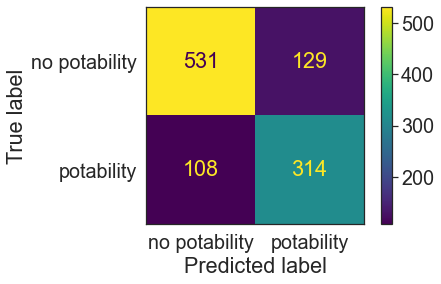

In [30]:
%%time
ConfusionMatrixDisplay.from_estimator(model_1, x_test, y_test, display_labels = ['no potability','potability'])

Notiamo che tende a classificare abbastanza bene entrambe

Effettuiamo il report della classificazione

In [31]:
target_names = ['no potability', 'potability']
print(classification_report(y_test, model_1.predict(x_test), target_names=target_names))

               precision    recall  f1-score   support

no potability       0.83      0.80      0.82       660
   potability       0.71      0.74      0.73       422

     accuracy                           0.78      1082
    macro avg       0.77      0.77      0.77      1082
 weighted avg       0.78      0.78      0.78      1082



### Grid n°2 (Ada Boost Classiffier) e metriche di valutazione

In [32]:
%%time
n = [50,100,150]
n1 = [0.1, 0.3, 0.5, 0.7, 1]
parameters = {'n_estimators' : n, 'learning_rate' : n1}
Grid = GridSearchCV(ABC, parameters,cv=skf)
Grid.fit(x_train, y_train)
model_2 = Grid.best_estimator_
result = cross_val_score(model_2, x_train, y_train)
print('CV_Score :', result.mean())
model_2.fit(x_train, y_train)
print('Accuracy_Score :', model_2.score(x_test, y_test))

CV_Score : 0.7127688639411852
Accuracy_Score : 0.6977818853974121
Wall time: 24.4 s


Confusion matrix

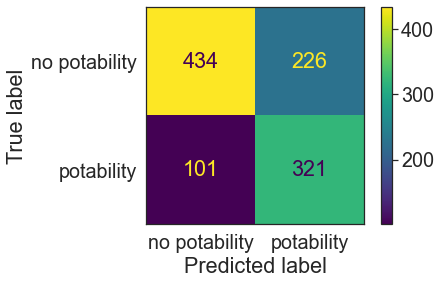

In [33]:
ConfusionMatrixDisplay.from_estimator(model_2, x_test, y_test, display_labels = ['no potability','potability'])

#Notiamo dai risultati che tende a classificare meno bene le no potability rispetto al modello precedente

Effettuiamo il report della classificazione

In [34]:
target_names = ['no potability', 'potability']
print(classification_report(y_test, model_2.predict(x_test), target_names=target_names))

               precision    recall  f1-score   support

no potability       0.81      0.66      0.73       660
   potability       0.59      0.76      0.66       422

     accuracy                           0.70      1082
    macro avg       0.70      0.71      0.69      1082
 weighted avg       0.72      0.70      0.70      1082



## Fase 2

In questa fase andro a selezionare le features (4) per fare la classificazione e faro un veloce spot check tra Random Forest Classifier, Ada Boost Classifier e Gradient Boosting Classifier e scegliero 2 modelli con il cross validation score piu alti per poi ottimizarli con gridsearchcv e infine testarli sul test set (dati mai visti) 

### Effettuiamo Anova test per selezionare i 4 feature piu rilevanti

In [35]:
SKB = SelectKBest(f_classif, k=4) # k sono il numero di features da selezionare
x2_train = SKB.fit_transform(x_train, y_train)
x2_test = SKB.transform(x_test)
y2_train = y_train
y2_test = y_test

### Modello n°1 - Random Forest Classifier

In [36]:
%%time
RFC = RandomForestClassifier(random_state=seed)
result = cross_val_score(RFC, x2_train, y2_train, cv = skf)
print(result.mean())

0.6594804033580051
Wall time: 1.66 s


### Modello n°2 - Ada Boost Classifier

In [37]:
%%time
ABC = AdaBoostClassifier(random_state=seed)
result = cross_val_score(ABC, x2_train, y2_train, cv = skf)
print(result.mean())

0.631811633798619
Wall time: 527 ms


### Modello n°3 - SVC

In [38]:
%%time
svc = SVC(random_state=seed)
result = cross_val_score(svc, x2_train, y2_train, cv = skf)
print(result.mean())

0.5146606394780852
Wall time: 1.26 s


Notiamo che applicando una selezione di features i risultati hanno peggioramento rispetto a utilizzare tutte le features

Passiamo alla fase successiva dove andrò a ottimizare i parametri dei 2 modelli scelti con GridSearchCv, che sarebbero RFC e ABC

### Grid n°1 (Random Forest Classification) e metriche di valutazione

In [39]:
%%time
Numero = [n for n in range(1,20)]
parameters = {'max_depth' : Numero}
Grid = GridSearchCV(RFC, parameters, cv = skf)
Grid.fit(x2_train, y2_train)
model_1 = Grid.best_estimator_
result = cross_val_score(model_1, x2_train, y2_train, cv = skf)
print('CV_Score :', result.mean())
model_1.fit(x2_train, y2_train)
print('Accuracy_Score :', model_1.score(x2_test, y2_test))

CV_Score : 0.6635553789346448
Accuracy_Score : 0.6256931608133087
Wall time: 26.8 s


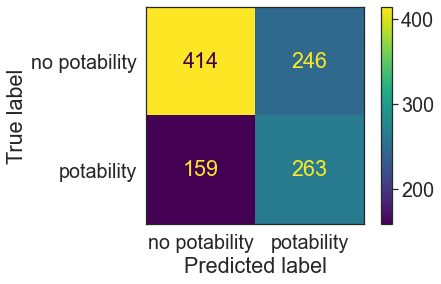

In [40]:
ConfusionMatrixDisplay.from_estimator(model_1, x2_test, y2_test, display_labels = ['no potability','potability'])

#Notiamo dai risultati che tende a classificare un po male le no potability

Metriche di classificazione

In [41]:
target_names = ['no potability', 'potability']
print(classification_report(y2_test, model_1.predict(x2_test), target_names=target_names))

               precision    recall  f1-score   support

no potability       0.72      0.63      0.67       660
   potability       0.52      0.62      0.56       422

     accuracy                           0.63      1082
    macro avg       0.62      0.63      0.62      1082
 weighted avg       0.64      0.63      0.63      1082



#Le metriche tendono a essere decenti con eccetto della precision delle potability è abbastanza basso come si vede dal confusion matrix che sbaglia un po a classificare le no potability

### Grid n°2 (ABC) e metriche di valutazione

In [42]:
%%time
n = [50,100,150]
n1 = [0.1, 0.3, 0.5, 0.7, 1]
parameters = {'n_estimators' : n, 'learning_rate' : n1}
Grid = GridSearchCV(ABC, parameters, cv = skf)
Grid.fit(x2_train, y2_train)
model_2 = Grid.best_estimator_
result = cross_val_score(model_2, x2_train, y2_train, cv = skf)
print('CV_Score :', result.mean())
model_1.fit(x2_train, y2_train)
print('Test_Score :', model_2.score(x2_test, y2_test))

CV_Score : 0.6399508221151458
Test_Score : 0.5998151571164511
Wall time: 17.9 s


Vediamo il confusion matrix

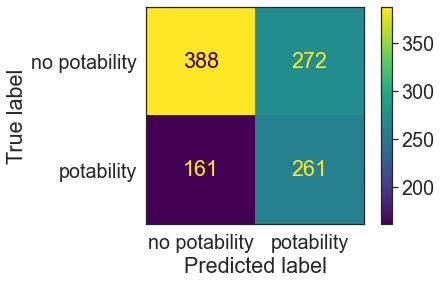

In [43]:
ConfusionMatrixDisplay.from_estimator(model_2, x2_test, y2_test, display_labels = ['no potability','potability'])

#Stesso problema del modello precedente ma piu accentuato

Controlliamo le varie metriche di classificazione

In [44]:
target_names = ['no potability', 'potability']
print(classification_report(y2_test, model_2.predict(x2_test), target_names=target_names))

               precision    recall  f1-score   support

no potability       0.71      0.59      0.64       660
   potability       0.49      0.62      0.55       422

     accuracy                           0.60      1082
    macro avg       0.60      0.60      0.59      1082
 weighted avg       0.62      0.60      0.60      1082



#La precision delle potability e del recall di no potability è abbastanza basso come si vede dal confusion matrix che classifica quasi la meta in potability invece di no potability

## Conclusione

#Concludiamo che riducendo delle features si dimostra di aver un peggioramento rispetto al non, notiamo anche che la Random Forest Classifier tende a essere il migliore in entrambi casi e i risultati migliori sono dati dal Random Forest Classifier con tutte le features

Considerazioni:

Per migliorare le perfomance della classificazione si potrebbe usare un modello piu complesso tra cui, ho fatto una veloce prova, xgboost oppure di inserire altre caratteristiche dell'acqua o dati. (Ps: di recente avevo letto un articolo che spiegava che  i dati utilizzati per il training erano quelli che davanno un vantaggio dai competitor e non il modello, questo spiegarebbe perché sono opensource, comunque molto interessante l'articolo) 